In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import floor
from warnings import filterwarnings

filterwarnings("ignore")
%run "Black&scholes_trabalho.ipynb"
%run "monte_carlo.ipynb"
%run "mle.ipynb"

In [2]:
def get_data(ticker, start, end, period):
    ticker = yf.Ticker(ticker)
    df = ticker.history(start=start, end=end, period=period)
    returns = df.Close.pct_change()
    log_returns = (np.log(df.Close.shift(1)) - np.log(df.Close)).dropna()
    return np.mean(log_returns), np.std(log_returns), log_returns

In [3]:
mu_0, sigma_0, sp_returns =  get_data(ticker="^GSPC", start="2020-01-01", end="2020-12-31", period="1d")

#### a) Estimate the model parameters and corresponding confidence intervals using S&P Stock Market Index daily data from January 1 to December 31, 2020. Note: Use maximum likelihood methods for the estimation of parameters.


In [4]:
params_mle = minimize(log_likelihood, x0=[mu_0, sigma_0], args=(sp_returns,), method='Nelder-Mead')['x']
mu_mle, sigma_mle = params_mle

# Calculate the standard errors of the estimated parameters
results = sm.GLS(sp_returns, sm.tools.add_constant(sp_returns), sigma=abs(sigma_mle)).fit()
se_mu = results.bse[0]
se_sigma = results.bse[1]

# # Calculate 95% confidence intervals
mu_ci = norm.interval(0.99, loc=mu_mle, scale=se_mu)
sigma_ci = norm.interval(0.99, loc=sigma_mle, scale=se_sigma)

In [5]:
print("Daily return MLE estimation: ", round(mu_mle, 5))
print("C.Interval 95%;", f"CI_95% = [{round(mu_ci[0], 5)}, {round(mu_ci[1], 5)}]")
print("Daily Standard Deviation of returns MLE estimation: ", round(sigma_mle, 2))
print("C.Interval 95%;", f"CI_95% = [{round(sigma_ci[0], 2)}, {round(sigma_ci[1], 2)}]")

Daily return MLE estimation:  -0.00054
C.Interval 95%; CI_95% = [-0.00054, -0.00054]
Daily Standard Deviation of returns MLE estimation:  0.02
C.Interval 95%; CI_95% = [0.02, 0.02]


In [6]:
print("Annual return MLE estimation: ", round(mu_mle*252, 5))
print("C.Interval 95%;", f"CI_95% = [{round(mu_ci[0]*252, 5)}, {round(mu_ci[1]*252, 5)}]")
print("Annual Standard Deviation of returns MLE estimation: ", round(sigma_mle*np.sqrt(252), 2))
print("C.Interval 95%;", f"CI_95% = [{round(sigma_ci[0]*np.sqrt(252), 7)}, {round(sigma_ci[1]*np.sqrt(252), 7)}]")

Annual return MLE estimation:  -0.13643
C.Interval 95%; CI_95% = [-0.13643, -0.13643]
Annual Standard Deviation of returns MLE estimation:  0.35
C.Interval 95%; CI_95% = [0.3474244, 0.3474244]


#### b) Consider an European-style Call and a Put option contracts with the following parameters:
* Strike Price : 4000
* Underlying asset price : 3934.83 
* Maturity date : 21/09/2021
* Trade Date : 15/02/2021
* Risk-free interest rate : 3% 
* Dividend yield : 1%

#### c) Estimate the Call and Put option prices using the generalized Black-Scholes formula 

In [7]:
#Parameters
date_format = "%d/%m/%Y"

date1 = datetime.strptime("21/09/2021", date_format)
date2 = datetime.strptime("15/02/2021", date_format)

delta = date1 - date2

S = 3934.83
K = 4000
T = delta.days/252
r = 0.03
q = 0.01
sigma = sigma_mle*np.sqrt(252)
call = bs_call(S, K, T, q, r, sigma)
put = bs_put(S, K, T, q, r, sigma)

In [8]:
call

502.1926580276686

In [9]:
put

498.7812006223728

#### d) Confirm that the put-call parity holds.

In [10]:
call+K*np.exp(-r*T)

4399.718608517605

In [11]:
put+S* np.exp(-q*T)

4399.7186085176045

In [12]:
put_call_parity = round(call+K*np.exp(-r*T), 2) == round(put+S* np.exp(-q*T), 2)
if put_call_parity:
    print("Put call parity holds")
else:
    print("Premiums are inconsistent with put call parity")

Put call parity holds


#### e) Estimate and analyse the Greeks (e.g., delta, gamma, theta, ….) for both contracts and simulate a delta hedging strategy.

#### Call 

In [13]:
call_delta_ = round(call_delta(S, K, T, q, r, sigma), 2)
call_gamma_ =round(call_gamma(S, K, T, q, r, sigma), 5)
call_vega_ = round(call_vega(S, K, T, q, r, sigma), 2)
call_theta_ = round(call_theta(S, K, T, q, r, sigma), 2)
call_rho_ = round(call_rho(S, K, T, q, r, sigma), 2)
print(f'Call Greek: delta = {call_delta_}')
print(f'Call Greek: gamma = {call_gamma_}')
print(f'Call Greek: vega = {call_vega_}')
print(f'Call Greek: theta = {call_theta_}')
print(f'Call Greek: rho = {call_rho_}')

Call Greek: delta = 0.56
Call Greek: gamma = 0.00031
Call Greek: vega = 1428.06
Call Greek: theta = -318.29
Call Greek: rho = 1473.05


#### Put 

In [14]:
put_delta_ = round(put_delta(S, K, T, q, r, sigma), 2)
put_gamma_ =round(put_gamma(S, K, T, q, r, sigma), 5)
put_vega_ = round(put_vega(S, K, T, q, r, sigma), 2)
put_theta_ = round(put_theta(S, K, T, q, r, sigma), 2)
put_rho_ = round(put_rho(S, K, T, q, r, sigma), 2)
print(f'Put Greek: delta = {put_delta_}')
print(f'Put Greek: gamma = {put_gamma_}')
print(f'Put Greek: vega = {put_vega_}')
print(f'Put Greek: theta = {put_theta_}')
print(f'Put Greek: rho = {put_rho_}')

Put Greek: delta = -0.43
Put Greek: gamma = 0.00031
Put Greek: vega = 1428.06
Put Greek: theta = -240.37
Put Greek: rho = -1898.62


##### Delta-neutral portfolio (Dynamic Hedging)

Approach: 
* We will start allocating an initial capital of 100,000 USD, take our first 10 underlying asset random walks and simulate a delta neutral trading strategy with daily rebalancing.
* Assuming no transaction costs

In [22]:
# shortar 100 calls e ir long 57 shares (100 * delta call) -> delta neutral 
# portfolio = -100 C + 57 S

In [23]:
# long 100 puts e ir short 43 shares (100*delta put) -> delta neutral 
# portfolio = 100 P - 43 S

In [15]:
path_, _, _ = monte_carlo_vectorized(S, K, sigma, r, q, T, int(delta.days), 50000)
path_.shape

(218, 50000)

In [16]:
delta_paths = path_[:, :10]

#### $\pi_{t} + w_{1}\pi_{t} - S \Delta_{P} \times (\frac{-w_{1}\pi_{t}}{P}) = 0$

* $\pi_{t}$: Balance at time t

* $w_{1}$: Weight of the portfolio self financed with short sell of puts

* $S$ : index price

* $P$ : put price

* $\Delta_{P}$ : put delta

* $(\frac{-w_{1}\pi_{t}}{P})$ : number of puts sold short

* $(\pi_{t} + w_{1}\pi_{t})$ : Amount available to purchase shares

* $S \Delta_{P} \times (\frac{-w_{1}\pi_{t}}{P})$ : Amount of purchased shares

In [16]:
balance = 100000
w1 = -balance/(balance + (S*put_delta_*balance/put))


n_of_puts_S = floor(balance*w1/put)

print(f"Delta neutral, self-financing portflio at time 0, is: short {n_of_puts_S} puts and going long {floor((-put_delta_) * n_of_puts_S)} index contracts (allocating all our available capital)")

Delta neutral, self-financing portflio at time 0, is: short 83 puts and going long 43 index contracts (allocating all our available capital)


###### Know our upper bound. But if our delta goes even down?! We would not have more capital to rebalance our portfolio(buy more shares). In order to be able to rebalance (purchase more shares), we will keep a safety margin of 10 put options short. 

In [45]:
n_of_puts_S = floor(balance*w1/put) - 10
exc_capital = round(balance + n_of_puts_S*put -  S*floor(-put_delta_*n_of_puts_S), 2)
print(f"Delta neutral, self-financing portflio at time 0, is: short {n_of_puts_S} puts and going long {floor(-put_delta_ * n_of_puts_S)}, we are left over with a capital of {exc_capital} USD to rebalance")

Delta neutral, self-financing portflio at time 0, is: short 73 puts and going long 31, we are left over with a capital of 14431.3 USD to rebalance


In [34]:
n_of_puts_S

73

In [133]:
def rebalance(df:pd.DataFrame, col1:str, col2:str, col3:str, col4:str, col5:str, n_of_puts_S : int = n_of_puts_S) -> pd.Series:
    for i in range(1, len(df)):
        df[col1][i] = df[col1][i-1] - df[col2][i]*df[col3][i]
        if i == len(df)-1:
            df[col1][i] += df[col4][i] * df[col3][i] - df[col5][i] * n_of_puts_S
    return df[col1]


def simulate_delta_neutral(paths: np.array, n: int, K:int, T:float, sigma:float, r:float, q:float, delta_func = put_delta, BS_func = bs_put, balance : int = balance, n_of_puts_S : int = n_of_puts_S) -> pd.DataFrame:
    paths_ = paths[:, :n]
    columns = [f"S_{i}" for i in range(n)]
    df = pd.DataFrame(data=paths_, columns=columns)
    df["dt"] = [(T) - i/252 for i in range(len(paths))]
    # assumed constants
    df["K"] = K
    df["sigma"] = sigma
    df["r"] = r
    df["q"] = q
    
    CFF = []
    deltas = []
    Sim = []
    option_val = []
    actv = []
    current_position = []
    
    for i in range(n):
        df[f"delta_{i}"] = df.apply(lambda row: round(delta_func(row[f"S_{i}"], row["K"]  , row["dt"]  , row["q"]  , row["r"]  , row["sigma"]), 2), axis=1)
        df[f"f_value_{i}"] = df.apply(lambda row: round(BS_func(row[f"S_{i}"], row["K"]  , row["dt"]  , row["q"]  , row["r"]  , row["sigma"]), 2), axis=1)
        df[f"delta_diff_{i}"] = df[f"delta_{i}"].shift(1) - df[f"delta_{i}"]
        df[f"shares_rebalanced_{i}"] = (df[f"delta_diff_{i}"] * n_of_puts_S)
        df[f"shares_rebalanced_{i}"].iloc[0] = floor(-put_delta_ * n_of_puts_S)
        df[f"shares_rebalanced_{i}"] = df[f"shares_rebalanced_{i}"].astype(int)
        df[f"current_position_{i}"] = df[f"shares_rebalanced_{i}"].cumsum()
        df[f"CFF_{i}"] = 0
        df[f"CFF_{i}"][0] = balance + df[f"f_value_{i}"][0] * n_of_puts_S - df[f"S_{i}"][0] * df[f"shares_rebalanced_{i}"][0]
        df[f"CFF_{i}"] = rebalance(df, f"CFF_{i}", f"shares_rebalanced_{i}", f"S_{i}", f"current_position_{i}", f"f_value_{i}")
        df[f"current_position_{i}"].iloc[-1] = 0
        CFF.append(f"CFF_{i}")
        deltas.append(f"delta_{i}")
        Sim.append(f"S_{i}")
        option_val.append(f"f_value_{i}")
        actv.append(f"shares_rebalanced_{i}")
        current_position.append(f"current_position_{i}")
        
    
    return df[CFF], df[deltas], df[Sim], df[option_val], df[actv], df[current_position]

In [134]:
CFFS, deltas, simulations, B_s_put_price, hedging_activity, Position_on_index = simulate_delta_neutral(path_, 10, K, T, sigma, r, q)

In [162]:
CFFS

,CFF_0,CFF_1,CFF_2,CFF_3,CFF_4,CFF_5,CFF_6,CFF_7,CFF_8,CFF_9
0,14431,14431,14431,14431,14431,14431,14431,14431,14431,14431
1,14431,14431,22579,35460,14431,18432,22536,18442,22475,22485
2,22582,6794,22579,31311,14431,18432,22536,10708,30765,30740
3,30980,6794,18550,39864,14431,18432,26656,10708,30765,26666
4,39669,6794,10725,31567,14431,6962,30829,10708,30765,22647
...,...,...,...,...,...,...,...,...,...,...
213,149514,-89582,-91185,113766,-75628,-91578,104775,128351,101370,53880
214,149514,-89582,-91185,135344,-75628,-91578,104775,128351,101370,6207
215,149514,-89582,-91185,144044,-75628,-91578,104775,128351,101370,46525
216,149514,-89582,-91185,144044,-75628,-91578,104775,128351,101370,-104921


#### f) Estimate the fair value of the call & put option contracts using Monte Carlo simulation methods considering 50000 simulations and compare its results with those obtained using the Black-Scholes formula.

In [20]:
_, call_, put_ = monte_carlo_vectorized(S, K, sigma, r, q, T, int(delta.days), 50000)

In [ ]:
path_.plot(legend=False)
plt.show()

#### g) Estimate the Greeks (e.g., delta, gamma, theta, ….) for both contracts.


In [ ]:
print(f'Call Pathwise Greek: delta = {round(Pathwise_delta('call', S, K, path_, r, T), 2)}')
print(f'Call Pathwise Greek: gamma = {round(call_gamma(S, K, T, q, r, sigma), 5)}')
print(f'Call Pathwise Greek: vega = {round(call_vega(S, K, T, q, r, sigma), 2)}')
print(f'Call Pathwise Greek: theta = {round(call_theta(S, K, T, q, r, sigma), 2)}')
print(f'Call Pathwise Greek: rho = {round(call_rho(S, K, T, q, r, sigma), 2)}')

#### h) Estimate the fair value of an American-Style Call with term sheet defined in (b) using Monte Carlo simulation methods and compare the results with that of its European-style equivalent. 

### Appendix 

#### Plots 

##### Dynamic Hedging

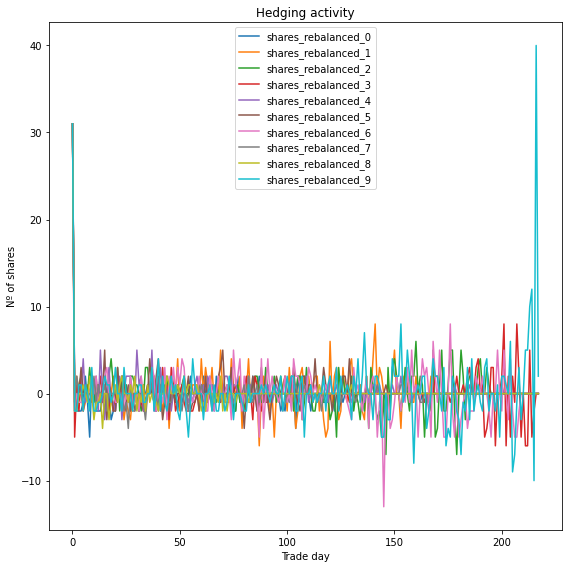

In [165]:
hedging_activity.plot(figsize=(8, 8))
plt.title("Hedging activity")
plt.xlabel("Trade day")
plt.ylabel("Nº of shares")
plt.tight_layout()
plt.show()

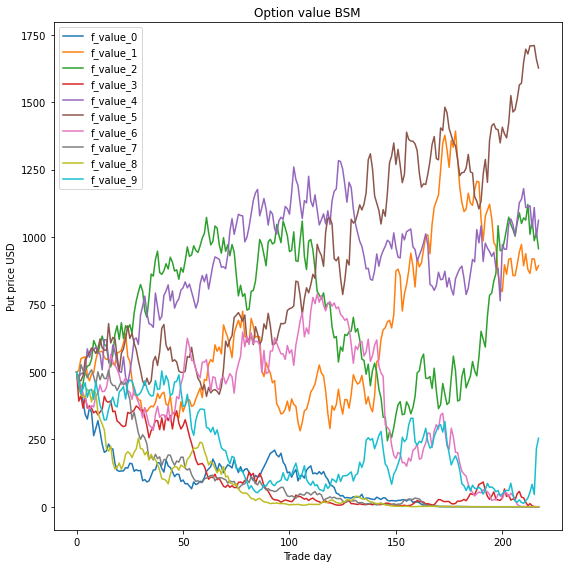

In [177]:
B_s_put_price.plot(figsize=(8, 8))
plt.title("Option value BSM")
plt.xlabel("Trade day")
plt.ylabel("Put price USD")
plt.tight_layout()
plt.show()

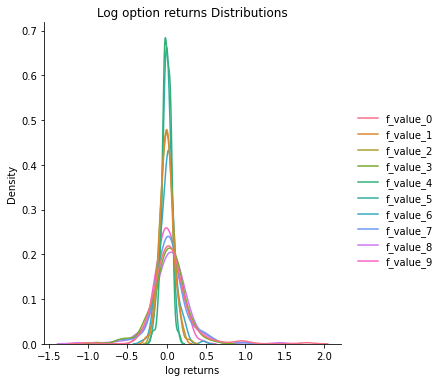

In [195]:
log_opt_returns = (np.log(B_s_put_price.shift(1)) - np.log(B_s_put_price)).dropna()
sns.displot(log_opt_returns, kind="kde", palette="husl")
plt.title("Log option returns Distributions")
plt.xlabel("log returns")
plt.show()

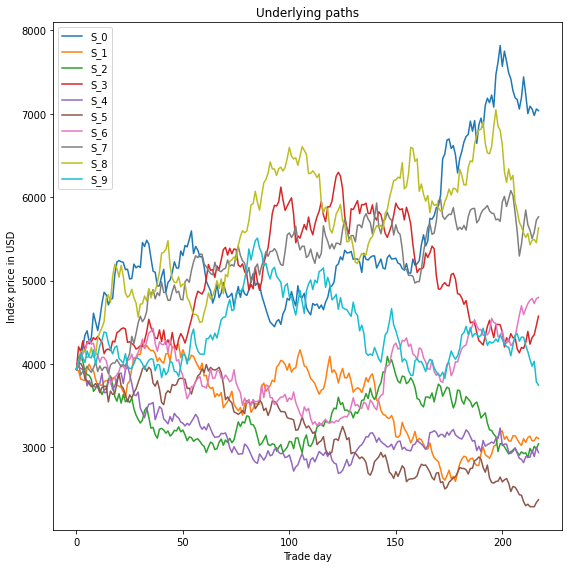

In [183]:
simulations.plot(figsize=(8, 8))
plt.title("Underlying paths")
plt.xlabel("Trade day")
plt.ylabel("Index price in USD")
plt.tight_layout()
plt.show()

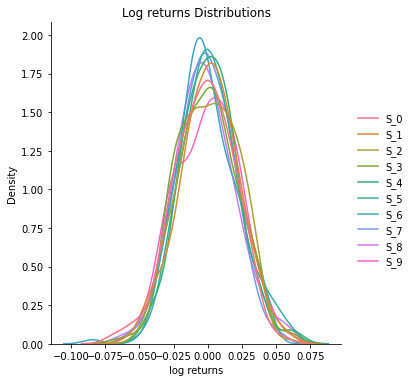

In [194]:
log_returns = (np.log(simulations.shift(1)) - np.log(simulations)).dropna()
sns.displot(log_returns, kind="kde", palette="husl")
plt.title("Log returns Distributions")
plt.xlabel("log returns")
plt.show()

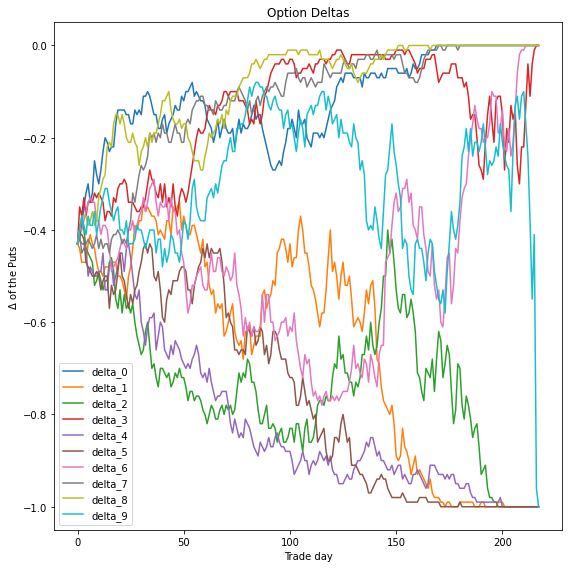

In [182]:
deltas.plot(figsize=(8, 8))
plt.title("Option Deltas")
plt.xlabel("Trade day")
plt.ylabel("$\Delta$ of the Puts")
plt.tight_layout()
plt.show()

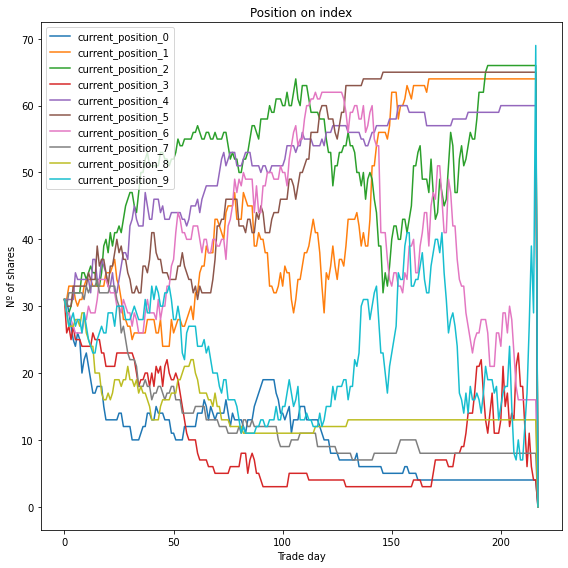

In [166]:
Position_on_index.plot(figsize=(8, 8))
plt.title("Position on index")
plt.xlabel("Trade day")
plt.ylabel("Nº of shares")
plt.tight_layout()
plt.show()

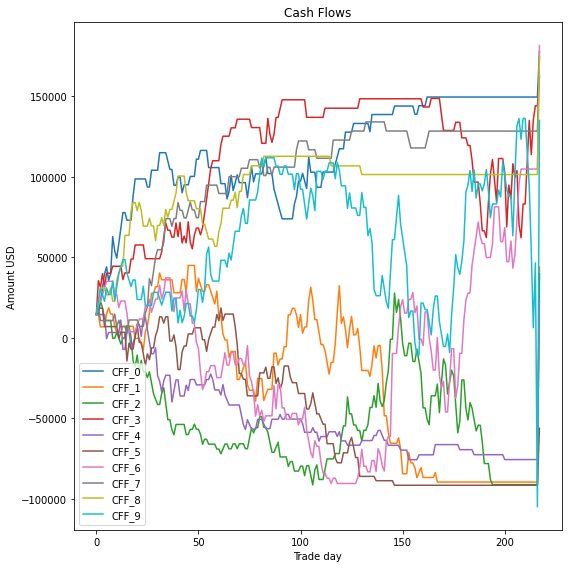

In [168]:
CFFS.plot(figsize=(8, 8))
plt.title("Cash Flows")
plt.xlabel("Trade day")
plt.ylabel("Amount USD")
plt.tight_layout()
plt.show()

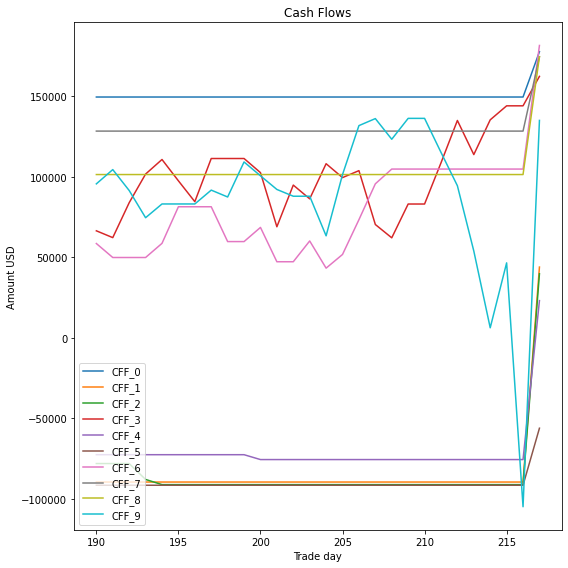

In [174]:
CFFS.iloc[190:, ].plot(figsize=(8, 8))
plt.title("Cash Flows")
plt.xlabel("Trade day")
plt.ylabel("Amount USD")
plt.tight_layout()
plt.legend(loc="lower left")
plt.show()